In [58]:
import tweepy
import time
import pandas as pd
from py2neo import Graph, Node, Relationship

from igraph import Graph as IGraph
import igraph

from IPython.core.display import HTML
from IPython.html.widgets import FloatProgress, Label
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)


OAUTH_KEY = ''
OAUTH_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''

NEO4J_USER = ''
NEO4J_SECRET = ''

## Select seeds for search networks
I select small (1000-1500) sized bot network and pick 4 random members from it

In [24]:
seeds = ['volya_belousova', 'egor4rgurev', 'kirillfrolovdw', 'ilyazhuchhj']

In [25]:
auth = tweepy.OAuthHandler(OAUTH_KEY, OAUTH_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
graph = Graph(user=NEO4J_USER, password=NEO4J_SECRET)

In [26]:
def get_follwers_by_id(account_id):
    ids = []
    for page in tweepy.Cursor(api.followers_ids, user_id=account_id).pages():
        print("FOLLOWERS: Next page for %s" % account_id)
        ids.extend(page)
    return ids

def get_friends_by_id(account_id):
    ids = []
    for page in tweepy.Cursor(api.friends_ids, user_id=account_id).pages():
        print("FRIENDS: Next page for %s" % account_id)
        ids.extend(page)
    return ids

def get_friends(account):
    ids = []
    for page in tweepy.Cursor(api.friends_ids, screen_name=account).pages():
        print("Next page for %s" % account)
        ids.extend(page)
    return ids

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

## Now search for friends of seed users

In [27]:
friend_ids = {}
for account in seeds:
    friend_ids[account] = get_friends(account)
    
commons = {}
for first in seeds:
    for second in seeds:
        if first != second:
            commons[(first, second)] = list(set(friend_ids[first]) & set(friend_ids[second]))


Next page for volya_belousova
Next page for egor4rgurev
Next page for kirillfrolovdw
Next page for ilyazhuchhj


In [28]:
all_users = friend_ids[seeds[0]]
for name in seeds:
    all_users = list(set(all_users) | set(friend_ids[name]))

## Show common users in total and per seed user

In [29]:
display("Common users: {0}".format(len(all_users)))

html = ["<table width=100%>"]
html.append('<tr><td></td>')
for name in seeds:
    html.append('<td>{0}</td>'.format(name))
html.append('</tr>')

for first in seeds:
    html.append('<tr><td>{0}</td>'.format(first))
    for second in seeds:
        if first != second:
            html.append('<td>{0}</td>'.format(len(commons[(first,second)])))
        else:
            html.append('<td>x</td>')
    html.append("</tr>")
html.append('</table>')

HTML(''.join(html))

'Common users: 5499'

,volya_belousova,egor4rgurev,kirillfrolovdw,ilyazhuchhj
volya_belousova,x,1567,1508,1528
egor4rgurev,1567,x,1422,1409
kirillfrolovdw,1508,1422,x,1409
ilyazhuchhj,1528,1409,1409,x


## Now search and populate neo4j database

In [30]:
graph.run("CREATE CONSTRAINT ON (u:UserRes) ASSERT u.id IS UNIQUE")
processed_users = []

In [31]:
for user_id in all_users:
    if user_id not in processed_users:
        user = Node("UserRes", id=user_id)
        graph.merge(user)
        try:
            for friend_id in get_follwers_by_id(user_id):
                if friend_id in all_users:
                    friend = Node("UserRes", id=friend_id)
                    graph.merge(friend)
                    graph.merge(Relationship(friend, "FRIEND_OF", user))

            for friend_id in get_friends_by_id(user_id):
                if friend_id in all_users:
                    friend = Node("UserRes", id=friend_id)
                    graph.merge(friend)
                    graph.merge(Relationship(user, "FRIEND_OF", friend))
            
            
                
        except tweepy.TweepError:
            print("User {0} has protected followers/friends".format(user_id))

        processed_users.append(user_id)
        print(float(len(processed_users)) / float(len(all_users)) * 100.0)

FOLLOWERS: Next page for 2826425701
FRIENDS: Next page for 2826425701
1.21840334606
FOLLOWERS: Next page for 790220991150579713
FRIENDS: Next page for 790220991150579713
1.23658847063
FOLLOWERS: Next page for 775798027374235648
FRIENDS: Next page for 775798027374235648
1.2547735952
FOLLOWERS: Next page for 2400764006
FRIENDS: Next page for 2400764006
1.27295871977
Rate limit reached. Sleeping for: 753
FOLLOWERS: Next page for 763767869624713216
FRIENDS: Next page for 763767869624713216
1.29114384434
FOLLOWERS: Next page for 1616822378
FRIENDS: Next page for 1616822378
1.3093289689
FOLLOWERS: Next page for 817365108
FOLLOWERS: Next page for 817365108
FRIENDS: Next page for 817365108
FRIENDS: Next page for 817365108
1.32751409347
FOLLOWERS: Next page for 788776319647674368
FRIENDS: Next page for 788776319647674368
1.34569921804
FOLLOWERS: Next page for 1972387958
FRIENDS: Next page for 1972387958
1.36388434261
FOLLOWERS: Next page for 764744673281896448
FRIENDS: Next page for 76474467328

## Get all users from neo4j and build graph

In [32]:
query = """
MATCH (user1:UserRes)-[:FRIEND_OF]->(user2:UserRes),
(user2:UserRes)-[:FRIEND_OF]->(user1)
RETURN user1.id, user2.id
"""

data = graph.run(query)

ig = IGraph.TupleList(data, weights=False)
ig.es["width"] = 1
ig.simplify(combine_edges={ "width": "sum" })

## Let's cluster graph and search for communities

In [33]:
clusters = IGraph.community_fastgreedy(ig)
clusters = clusters.as_clustering()

In [34]:
print("Found %d clusters" % len(clusters))

Found 11 clusters


## Let's make clusters dataframe

In [40]:
nodes = [{"id": node.index, "name": node["name"]} for node in ig.vs]

for node in nodes:
    node["cluster"] = clusters.membership[node["id"]]
    
nodes_df = pd.DataFrame(nodes)
edges = [{"source": x[0], "target": x[1]} for x in ig.get_edgelist()]
edges_df = pd.DataFrame(edges)
edges_counts = edges_df.groupby('source').count().reset_index().rename(columns = {'target': 'count'})

## Let's look to all clusters closely

In [37]:
nodes_df.groupby('cluster').count()

,id,name
cluster,,
0,2634,2634
1,2231,2231
2,14,14
3,2,2
4,13,13
5,2,2
6,15,15
7,18,18
8,3,3


We have only two clusters with significant user count.
Let's check first

In [50]:
first_cluster = nodes_df[nodes_df["cluster"] == 0][["id", "name"]]

## Join edges to users

In [55]:
first_cluster_counts = first_cluster.set_index('id').join(edges_counts.set_index('source')).reset_index()

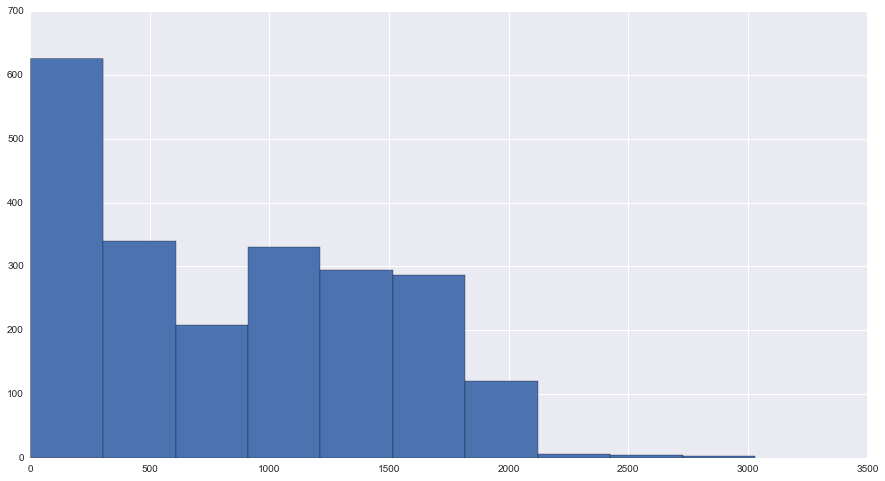

In [59]:
first_cluster_counts["count"].hist()

## Let's look to all groups

In [73]:
for group in range(20):
    start = group * 100
    stop = (group + 1) * 100
    users_slice = first_cluster_counts[(first_cluster_counts["count"] > start) & (first_cluster_counts["count"] < stop)]
    print("Users from %d to %d has %d" %(start, stop, users_slice.count()[0]))
    display(users_slice[:10])

Users from 0 to 100 has 394


,id,name,count
1513,2468,2795927954,93.0
1631,2619,784969785838800896,82.0
1644,2649,4806528018,72.0
1646,2651,783974457169874944,97.0
1650,2659,1459802851,86.0
1653,2663,190408182,59.0
1661,2675,804313115739516928,32.0
1681,2695,1345411068,57.0
1684,2698,2195708516,78.0
1687,2701,700441793238851584,70.0


Users from 100 to 200 has 115


,id,name,count
430,719,809324281461096448,108.0
801,1352,783197080466690048,178.0
814,1375,632063294,141.0
838,1412,790208690611781634,194.0
851,1435,740088273398333440,162.0
1451,2344,790224559370829825,197.0
1466,2360,2193723318,172.0
1589,2549,3205555245,170.0
1591,2564,758523584184713216,139.0
1606,2586,20733757,103.0


Users from 200 to 300 has 109


,id,name,count
245,391,822434231947317248,287.0
520,868,2970884728,297.0
550,911,1601673594,272.0
813,1374,2326512966,271.0
828,1396,3276538915,227.0
833,1403,805565471114133504,272.0
836,1410,635372371,253.0
1269,2019,159071440,288.0
1409,2282,503640860,238.0
1420,2296,3083639368,284.0


Users from 300 to 400 has 127


,id,name,count
571,949,788773483312451584,343.0
738,1247,604261155,338.0
1140,1828,788927524034183168,314.0
1193,1887,799328732729249792,322.0
1196,1890,1341840876,337.0
1198,1892,392047244,344.0
1201,1895,3015134789,353.0
1255,1988,788816863262310400,399.0
1333,2175,198283355,383.0
1339,2181,789040374912286720,398.0


Users from 400 to 500 has 113


,id,name,count
542,901,929372431,448.0
772,1297,791532800268705792,412.0
798,1347,750847710,427.0
992,1592,790629135840317440,409.0
998,1598,788956110007009280,455.0
1195,1889,4019170883,497.0
1197,1891,703139084496084993,424.0
1202,1896,2284508448,432.0
1203,1897,109817109,450.0
1226,1921,789309188161888256,476.0


Users from 500 to 600 has 94


,id,name,count
55,80,785862195846545408,546.0
106,173,125319468,587.0
213,338,229012262,510.0
533,887,788929596209111040,537.0
761,1284,1445224854,547.0
922,1522,790617151493271554,506.0
1194,1888,532171645,511.0
1200,1894,377245304,564.0
1212,1907,789150314498756609,516.0
1231,1926,800770999272673280,509.0


Users from 600 to 700 has 75


,id,name,count
614,1022,740974122163970048,675.0
742,1254,789318935732690944,664.0
845,1425,760011195751469056,623.0
1018,1628,789085669050159104,616.0
1020,1631,789113295596769281,621.0
1057,1690,790226555935006721,660.0
1134,1814,790205605776592896,663.0
1176,1865,788762432332267520,690.0
1180,1869,788942325145796608,667.0
1182,1871,789006874637012992,680.0


Users from 700 to 800 has 63


,id,name,count
333,542,974858659,799.0
378,622,577335162,746.0
714,1199,789025393768591360,777.0
733,1235,811461391718711297,753.0
773,1298,813678292335202304,712.0
863,1455,790211688717058048,793.0
997,1597,788442658972831744,773.0
1015,1625,788953586181017601,780.0
1023,1640,789379126625001472,780.0
1025,1643,789515225083117568,773.0


Users from 800 to 900 has 73


,id,name,count
1,1,796426024238116866,835.0
45,67,783584574186123265,841.0
181,294,538522822,893.0
280,448,2396663347,868.0
334,548,515893594,842.0
390,642,570465479,883.0
403,666,101737099,894.0
510,845,788970609309061120,891.0
621,1038,788932279179542528,870.0
850,1434,1890861601,828.0


Users from 900 to 1000 has 82


,id,name,count
393,646,789329630503268352,974.0
489,811,377461268,903.0
513,854,4725791481,940.0
525,874,789029530144997376,912.0
708,1191,103353759,935.0
720,1210,4725935361,983.0
725,1219,391269540,982.0
765,1289,788765457654378496,974.0
831,1399,788772860915490816,977.0
834,1408,789512015496749057,983.0


Users from 1000 to 1100 has 135


,id,name,count
67,98,822148583747125252,1047.0
179,292,4724577143,1022.0
274,441,788961560106524672,1065.0
297,475,789129592271466496,1079.0
298,478,789122006331645952,1096.0
410,684,789030029145542656,1081.0
560,927,2399862787,1055.0
660,1108,806076531491672064,1099.0
687,1159,788652745825849344,1097.0
690,1164,788924704291774466,1048.0


Users from 1100 to 1200 has 103


,id,name,count
54,79,389332173,1130.0
84,126,789106859991035905,1181.0
86,130,789054563697487872,1195.0
143,232,789112369163173888,1121.0
231,372,482390443,1128.0
256,407,789094976739213313,1105.0
259,412,788818481571622912,1163.0
261,416,824194539569168384,1199.0
365,604,789010559270289408,1102.0
504,833,789482394944311296,1132.0


Users from 1200 to 1300 has 102


,id,name,count
98,152,816597605065093121,1294.0
137,219,789107117147820033,1256.0
178,291,788824481972228096,1223.0
196,314,789078655188303872,1205.0
253,402,788973385900494848,1285.0
416,698,788982820974755840,1283.0
427,715,788971861019398144,1274.0
437,727,788783590456881152,1279.0
459,766,788759714691710976,1286.0
466,778,789433058013261824,1270.0


Users from 1300 to 1400 has 96


,id,name,count
83,125,788859751715266561,1329.0
271,438,788970211235991552,1390.0
320,512,788642572981854209,1327.0
326,528,788930687139188737,1387.0
339,557,788993003490861056,1360.0
357,592,788800865230544900,1337.0
369,609,790627391525773314,1341.0
371,611,790217109154435072,1386.0
386,634,788996208564002816,1327.0
391,643,788807183613984768,1385.0


Users from 1400 to 1500 has 91


,id,name,count
220,349,788964725291905024,1478.0
248,396,790618798508412929,1452.0
275,442,788940753494048768,1469.0
288,463,788932282426003456,1452.0
289,464,788775030637391872,1482.0
292,468,789329874104250368,1434.0
303,484,788961370037444608,1498.0
324,519,789481918744129536,1410.0
325,521,790208018327691264,1499.0
329,531,788923405647175680,1466.0


Users from 1500 to 1600 has 107


,id,name,count
34,53,789520202056732672,1589.0
48,71,788993796025491456,1572.0
88,138,790626149000998913,1534.0
89,139,788974814799290368,1538.0
96,149,788775716796129280,1511.0
134,212,790211464942460928,1529.0
153,253,789465960193355777,1569.0
154,255,788918539461726208,1578.0
163,266,788799469831815168,1503.0
180,293,790617338999603200,1548.0


Users from 1600 to 1700 has 89


,id,name,count
15,26,790226695412445190,1615.0
28,45,790618191873581056,1627.0
53,78,789426293410373632,1655.0
76,115,790220705971535872,1653.0
79,118,788767516600524803,1685.0
111,180,3438934264,1638.0
116,187,789010785884332032,1695.0
126,202,788987798485360640,1693.0
132,210,788766556096430080,1681.0
141,225,788923566721040385,1632.0


Users from 1700 to 1800 has 89


,id,name,count
13,24,790211657373016064,1797.0
18,29,789357583501029376,1744.0
19,31,788928807998787584,1788.0
32,50,788943181924724736,1720.0
57,83,789413739346878464,1704.0
66,95,790225277431545857,1747.0
69,103,788938558845386752,1757.0
78,117,788963337669337088,1799.0
91,141,788788187787325442,1781.0
93,146,788795571620446209,1717.0


Users from 1800 to 1900 has 68


,id,name,count
0,0,790223237066129408,1885.0
3,6,789356444982382592,1866.0
4,7,788765922349682688,1810.0
6,9,790211627178221568,1877.0
11,21,788795994335051776,1846.0
16,27,788762768514117632,1873.0
24,37,788765752727785472,1807.0
26,43,788947182971940865,1860.0
29,46,789515019956477954,1860.0
31,48,788926486271131648,1824.0


Users from 1900 to 2000 has 41


,id,name,count
5,8,788781798205624320,1927.0
7,10,788777122038939648,1940.0
9,18,788780939249844224,1953.0
12,23,788415407568945154,1980.0
14,25,788928799996055552,1907.0
22,34,788958670587650048,1952.0
25,42,789496515983052801,1974.0
36,55,788939290789150720,1995.0
41,61,788806190880948225,1945.0
50,73,790620218804625408,1903.0


Looks like most bot accounts has followers/follows count from 1200 to 1900

Let's filter it

In [74]:
filtered_bots = first_cluster_counts[(first_cluster_counts["count"] > 1200) & (first_cluster_counts["count"] < 1900)]

In [75]:
print("We found %s bots in first approximation" % filtered_bots.count()[0])

We found 646 bots in first approximation


Now collect all information from these accounts and search for corellations

In [98]:
first_cluster_bots = []
for group in chunks(filtered_bots["name"].values, 100):
    for user in api.lookup_users(user_ids=list(group)):
        first_cluster_bots.append(user)

In [104]:
locations = [user.location for user in first_cluster_bots]

In [119]:
first_cluster_bots[0].favourites_count

35

In [121]:
possible_bot_users = pd.DataFrame([{'name': user.name, 'id': user.id, 'location': user.location, 'screen_name': user.screen_name, 'followers': user.followers_count, 'friends': user.friends_count, 'created_at': user.created_at, 'favorites': user.favourites_count} for user in first_cluster_bots])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127002e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bf0e090>]], dtype=object)

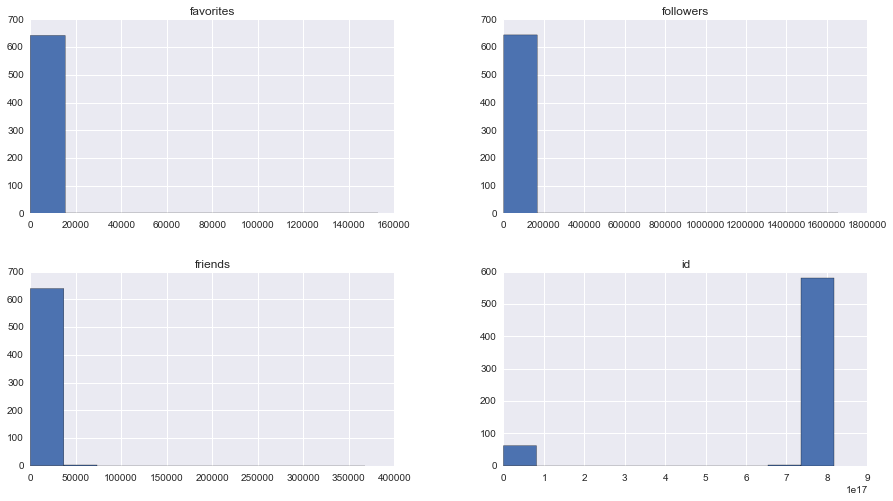

In [123]:
possible_bot_users.hist()

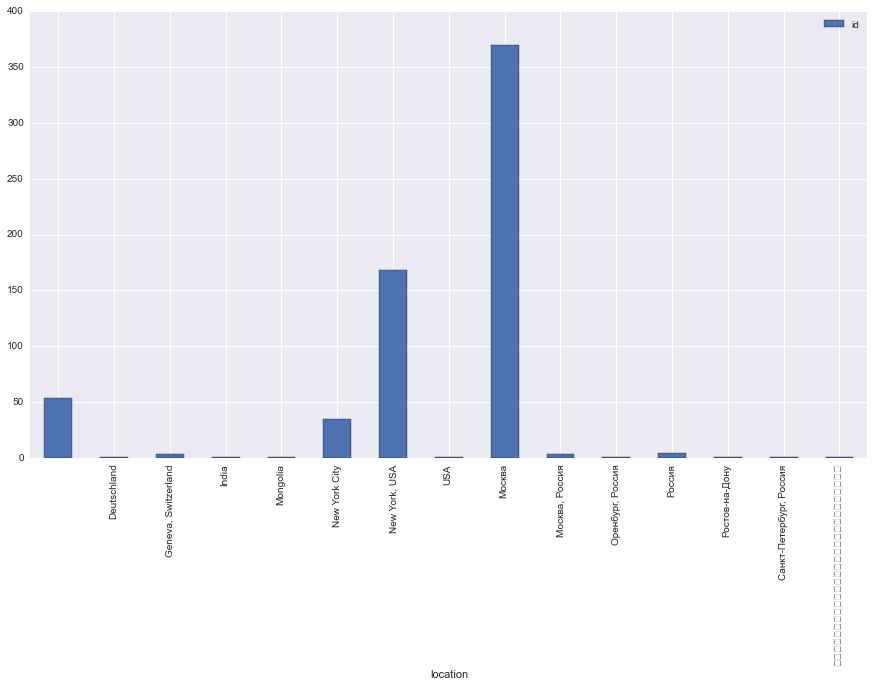

In [142]:
possible_bot_users[["id", "location"]].groupby('location').count().plot(kind='bar')

Ok, we have two significant values. Moscow and New York. Let's split dataset

In [145]:
moscow_users = possible_bot_users[possible_bot_users["location"] == u'Москва']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c959e50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c9aba10>]], dtype=object)

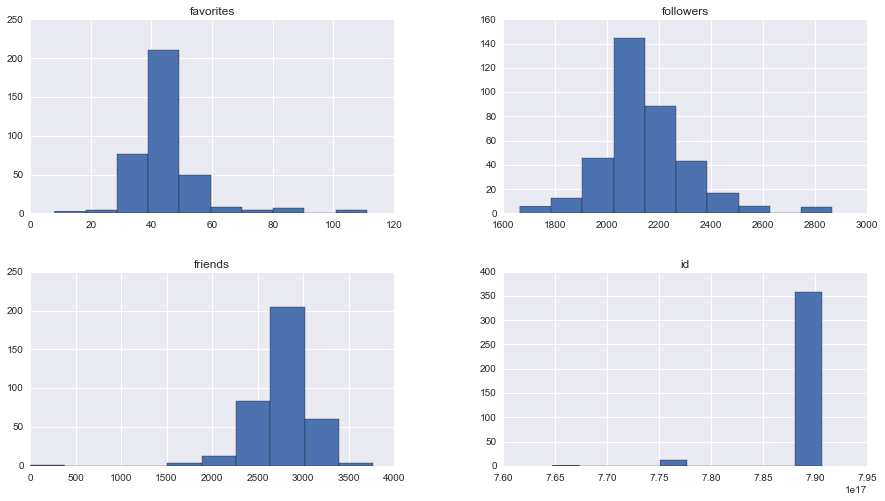

In [147]:
moscow_users.hist()

In [162]:
moscow_users[:10]

,created_at,favorites,followers,friends,id,location,name,screen_name
0,2016-10-23 16:07:56,35,1990,2729,790223237066129408,Москва,Селезнёва Светлана,vyacheslavshotf
3,2016-10-23 15:21:48,46,2198,2994,790211627178221568,Москва,Владимирова Ирина,valeriygjjno
8,2016-10-19 15:24:33,46,2007,2780,788762768514117632,Москва,Фомина Маргарита,albragin39
13,2016-10-24 18:17:20,49,1724,2078,790618191873581056,Москва,Веселова Вероника,yuriysh382m
14,2016-10-21 17:13:44,36,2060,2663,789515019956477954,Москва,Мухина Елизавета,dimashixr
15,2016-10-20 02:15:06,52,2044,2509,788926486271131648,Москва,Киселёва Ирина,egoroxmik
17,2016-10-24 18:01:50,39,1917,2290,790614289207951360,Москва,Субботина Марина,leoniddyjg
19,2016-10-19 08:13:37,45,2016,2838,788654322825437184,Москва,Суханова Алина,fatyansitnikov1
21,2016-10-19 18:10:46,35,2082,2936,788804598693847040,Москва,Зиновьева Полина,evgeniy05p1
22,2016-10-21 07:24:08,44,2018,2671,789366644627955712,Москва,Кириллова Зинаида,mikhailg48ku


Now check NY users

In [155]:
ny_users = possible_bot_users[possible_bot_users["location"] == u'New York, USA']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c600710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12d49e590>]], dtype=object)

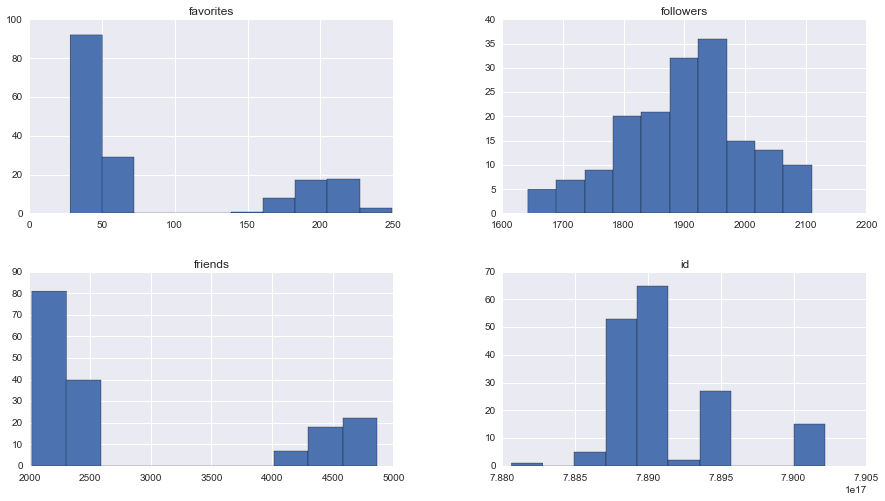

In [160]:
ny_users.hist()

In [161]:
ny_users[:10]

,created_at,favorites,followers,friends,id,location,name,screen_name
1,2016-10-21 06:43:36,43,1964,2346,789356444982382592,"New York, USA",Lane Helen,borisegorov2k3
2,2016-10-19 15:37:05,47,1868,2275,788765922349682688,"New York, USA",Perkins Emily,alc6jkarpov
4,2016-10-20 06:23:41,55,1866,2275,788989043195441152,"New York, USA",Lucas Joella,aleefimov7eti
5,2016-10-19 17:36:35,45,1912,2306,788795994335051776,"New York, USA",Randall Madeline,paveloeyak
6,2016-10-23 15:21:55,201,2004,4405,790211657373016064,"New York, USA",Sherman Hilary,eduardaygalkin
9,2016-10-21 06:48:08,28,1813,2132,789357583501029376,"New York, USA",Hamilton Shanna,eduard0uq2zhuk1
10,2016-10-20 02:24:20,229,2045,4812,788928807998787584,"New York, USA",Cross Patricia,igorvm2zimin
11,2016-10-19 15:36:25,43,1925,2354,788765752727785472,"New York, USA",Adams Priscillaц,ilya0b3pbe
16,2016-10-20 03:21:27,175,1979,4325,788943181924724736,"New York, USA",Lindsey Doris,aljxtzykov
18,2016-10-21 17:34:19,49,1679,2051,789520202056732672,"New York, USA",Lloyd Emily,arturgos90


## Conclusion
We have one twitter bot network on two languages: Russian and English. 
All bots have deep linking and posts random sentences every hour.

In [163]:
print("Moscow bots: %d, NY bots: %d, Total: %d" % (moscow_users.count()[0], ny_users.count()[0], moscow_users.count()[0] + ny_users.count()[0]))

Moscow bots: 370, NY bots: 168, Total: 538


Now export moscow and ny users to csv

In [167]:
ny_users.append(moscow_users).to_csv("./moscow_ny_bots.csv", encoding='utf8')